# NPL EDA on reviews.

In this notebook, we will apply NLP to better understand what separates high rating reviews and low rating reviews.

We will analyze a sample of 500,000 reviews from companies in the U.S. that have been reviewed on Glassdoor at least 100 times. I will view the distribution of review lengths for PROs and CONs. 

I will then train a CountVectorizer on the reviews. I will use these representations of reviews with Truncated SVD and Logistic Regression. I will label reviews to have an overall rating at least 4 and at most 3 because that almost separates the reviews 50-50. 

I will conclude by finding the words most associated with PROs and CONs.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import time

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import re
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

Using TensorFlow backend.
/Users/derekjung/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Import Glassdoor reviews

In [ ]:
start_time = time.time()

reviews = pd.read_csv('glassdoor_reviews_2.csv')

print('Took ' + str(time.time()-start_time) + ' seconds.')

## Cleaning reviews

We will begin cleaning our reviews. I did this in the notebook titled "import_glassdoor_Sept13", but I will try to make it more concise here.

In [5]:
#save initial version of reviews
reviews_original = reviews.copy()

In [6]:
start_time = time.time()

reviews = reviews_original.copy()

#each review's "Author Title" should be of format "Employee Status - Job Title"
# for example, "Current Employee - Senior Engineer"

#determine how many parts each review's "Author Title" has (should be 2)
reviews.loc[:,'title_length'] = reviews.loc[:,'Author Title'].apply(lambda x: len(x.split(' - ')))

#only consider reviews of proper format "Employee Status - Author Title"
reviews = reviews[reviews['title_length'] == 2]
#could be omitting some job titles with 'dash' in name,
#but decreasing number of reviews from 2631927 to 2615691 (<1% change, so don't care)

#'Author Title' of all reviews now 2
reviews = reviews.drop('title_length', axis=1)

#break up "Author Title" into two columns: "Employee Status" and "Job Title"
reviews.loc[:,'Employee Status'] = reviews.loc[:,'Author Title'].apply(lambda x: x.split(' - ')[0])
reviews.loc[:,'Job Title'] = reviews.loc[:,'Author Title'].apply(lambda x: x.split(' - ')[1])

#remove 10 reviews have incorrect "Employee Status" 
#("Employee Status" not like "Current Employee", "Former Intern", etc.)
reviews = reviews[reviews['Employee Status'] != 'module.emp-review.current-'] #remove 4 reviews
reviews = reviews[reviews['Employee Status'] != 'module.emp-review.former-'] #remove 6 reviews

#add extra columns that states if employee is current or former employee
reviews.loc[:,'current_or_former'] = reviews.loc[:,'Employee Status'].apply(lambda x: x.split(' ')[0])

print('Took ' + str(time.time()-start_time) + ' seconds.')

Took 71.15643787384033 seconds.


In [7]:
reviews.shape

(2615681, 38)

## Import companies info

In [8]:
companies = pd.read_csv('reviewed_companies.csv')

In [10]:
#percentage of companies with at most that many reviews
(companies.loc[:,'count'].value_counts()/companies.shape[0] * 100).sort_index().cumsum()

1         4.972565
2         9.087791
3        13.185871
4        16.923868
5        20.541838
6        23.593964
7        26.217421
8        28.497942
9        30.401235
10       32.270233
11       33.779150
12       35.236626
13       36.728395
14       38.185871
15       39.283265
16       40.329218
17       41.392318
18       42.369684
19       43.432785
20       44.238683
21       44.855967
22       45.661866
23       46.382030
24       47.153635
25       47.873800
26       48.559671
27       48.988340
28       49.845679
29       50.462963
30       50.994513
           ...    
1876     99.502743
1913     99.519890
1916     99.537037
1919     99.554184
1936     99.571331
1947     99.588477
2018     99.605624
2025     99.622771
2045     99.639918
2071     99.657064
2086     99.674211
2091     99.691358
2110     99.708505
2131     99.725652
2149     99.742798
2270     99.759945
2278     99.777092
2290     99.794239
2354     99.811385
2783     99.828532
3016     99.845679
3020     99.

In [11]:
#about 25% of companies have at least 100 reviews
#only consider companies with at least this many reviews
minimum_reviews_to_consider = 100

#companies with at least minimum_reviews_to_consider number of reviews
companies_at_least_min_reviews = companies[companies['count'] >= minimum_reviews_to_consider]

In [12]:
#only consider reviews from companies with at least 100 reviews
reviews_at_least_min_reviews = reviews[reviews['Company Id'].isin(companies_at_least_min_reviews.loc[:,'Company Id'])]

In [13]:
reviews_at_least_min_reviews.shape

(2339087, 38)

In [14]:
#filter to jobs in USA
reviews_at_least_min_reviews_usa = reviews_at_least_min_reviews[reviews_at_least_min_reviews['Author Country']=='USA']

print(reviews_at_least_min_reviews_usa.shape[0])

reviews_at_least_min_reviews_usa.head()

1007287


,Ticker Symbol,Entity Name,Dataset,CUSIP,ISIN,Unique ID,As Of Date,Review Url,Logo,Author Title,Author Location,Author Country,Summary,Description,PROs,CONs,Recommends Value,Recommends Description,Outlook Value,Outlook Description,CEO Review Value,CEO Review Description,Helpful Count,Rating: Overall,Rating: Work/Life Balance,Rating: Culture & Values,Rating: Career Opportunities,Rating: Comp & Benefits,Rating: Senior Management,Company Id,Company URL,Date Added,Date Updated,Ticker Sector,Ticker Industry,Employee Status,Job Title,current_or_former
4,nyse:xom,https://www.glassdoor.com?employer_id=237,2331755,30231G102,US30231G1022,3065906,2018-09-09 04:00:00+00,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/237/exxonmobi...,Former Employee - I T Analyst,"Houston, TX",USA,"""I.T. Analyst - Global Services Company""",I worked at ExxonMobil full-time (More than 10...,"Great benefits, smart co-workers, state of the...","Forced ranking, slow to adopt new technology, ...",1.0,Recommends,1.0,Positive Outlook,1.0,Approves of CEO,NaN,4,3.0,5.0,3.0,5.0,4.0,237,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 07:53:45.26833+00,2018-09-10 07:53:45.268361+00,Oil & Gas,Oil & Gas Producers,Former Employee,I T Analyst,Former
5,nyse:cat,https://www.glassdoor.com?employer_id=137,2330013,149123101,US1491231015,3065701,2018-09-09 04:00:00+00,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/137/caterpill...,Current Employee - Welder/Fabricator,"Aurora, IL",USA,"""Decent job with decent pay.""",I have been working at Caterpillar full-time (...,Steady 40 hours a week. Union job.,Company is more worried about the all might do...,1.0,Recommends,0.0,Neutral Outlook,-1.0,Disapproves of CEO,NaN,3,4.0,3.0,4.0,3.0,3.0,137,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 05:22:30.202947+00,2018-09-10 05:22:30.202988+00,Industrials,Industrial Engineering,Current Employee,Welder/Fabricator,Current
6,nyse:wrk,https://www.glassdoor.com?employer_id=1033056,2341899,96145D105,US96145D1054,3065903,2018-09-09 04:00:00+00,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/1033056/westr...,Current Employee - Quality,"Mebane, NC",USA,"""Quality""",I have been working at WestRock full-time (Mor...,Excellent health care and stock. 401k needs im...,No raise or pay adjustment in 2 years. Nothing...,-1.0,Doesn't Recommend,-1.0,Negative Outlook,-1.0,Disapproves of CEO,NaN,2,1.0,1.0,1.0,4.0,1.0,1033056,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 07:52:04.797509+00,2018-09-10 07:52:04.797545+00,Industrials,General Industrials,Current Employee,Quality,Current
10,sto:secu-b,https://www.glassdoor.com?employer_id=16559,2333979,NaN,NaN,3066089,2018-09-09 04:00:00+00,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/16559/securit...,Current Employee - Security Officer,"Hillsboro, OR",USA,"""I enjoy the people here""",I have been working at Securitas Security Serv...,"It is a very large, stable company that has be...",I've been there a month now and have no cons.,1.0,Recommends,1.0,Positive Outlook,1.0,Approves of CEO,NaN,5,4.0,5.0,5.0,4.0,5.0,16559,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 11:03:30.511047+00,2018-09-10 11:03:30.511088+00,NaN,NaN,Current Employee,Security Officer,Current
11,nyse:gs,https://www.glassdoor.com?employer_id=2800,2330564,38141G104,US38141G1040,3065765,2018-09-09 04:00:00+00,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/2800/goldman-...,Former Employee - Anonymous Employee,"New York, NY",USA,"""Great Company to Work for""",I worked at Goldman Sachs full-time (Less than...,Lots of learningLots of opportunities,Work PressureNeed to handle multiple task at s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1.0,5.0,5.0,5.0,4.0,2800,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 06:11:41.41912+00,2018-09-10 06:11:41.419162+00,Financials,Fi

## Preparing sample of reviews

I'll take a sample of 500,000 reviews from U.S. based companies that have been reviewed at least 100 times. The choice of 100 should help avoid the frequency of outliers.

In [15]:
#number of reviews to extract from reviews
size_of_sample = 500000

#extract size_of_sample reviews from reviews 
#(with at least set minimum number of reviews)
#set random state for reproducibility
reviews_sample = reviews_at_least_min_reviews_usa.sample(n=size_of_sample, 
                                                     random_state=21).reset_index()

In [18]:
#find percentage of reviews with different Overall Ratings
reviews_sample.loc[:,'Rating: Overall'].value_counts()/500000*100

4    27.7280
3    25.6060
5    19.0282
2    15.1230
1    12.5148
Name: Rating: Overall, dtype: float64

In [19]:
#make sure 'Rating: Overall' column is type <float>
reviews_sample.loc[:,'Rating: Overall'] = reviews_sample.loc[:,'Rating: Overall'].apply(lambda x: float(x))

#add column that states if overall rating was at least 4
reviews_sample.loc[:,'review_at_least_4'] = reviews_sample.loc[:,'Rating: Overall'].apply(lambda x: 1 if x >= 4.0 else 0)


In [21]:
#PRO/CON and label for sample of reviews
reviews_sample_pros_rating = reviews_sample.copy().loc[:,['PROs', 'review_at_least_4']]
reviews_sample_cons_rating = reviews_sample.copy().loc[:,['CONs', 'review_at_least_4']]


In [22]:
def standardize_text(df, text_field):
    '''
    Cleans column of DataFrame by making lowercase and replacing non-letters/punctuation with spaces.
    
    Args:
        df: DataFrame with text
        textfield: column to replace
        
    Returns:
        cleaned DataFrame
    '''
    df.loc[:, text_field] = df.loc[:, text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\-\n]"," ")
    df.loc[:, text_field] = df.loc[:, text_field].str.replace(r","," ")
    df.loc[:, text_field] = df.loc[:, text_field].str.lower()
    return df

reviews_sample_pros_rating = standardize_text(reviews_sample_pros_rating, 'PROs')
reviews_sample_cons_rating = standardize_text(reviews_sample_cons_rating, 'CONs')

In [23]:
#look at label balance
reviews_sample_cons_rating.groupby('review_at_least_4').count()

,CONs
review_at_least_4,
0,266219
1,233777


### Tokenize PROs and CONs

In [26]:
#tokenize reviews into separate words
tokenizer = RegexpTokenizer(r'\w+')

reviews_sample_pros_rating.loc[:,'PROs'] = reviews_sample_pros_rating.loc[:,'PROs'].apply(lambda x: str(x))
reviews_sample_cons_rating.loc[:,'CONs'] = reviews_sample_cons_rating.loc[:,'CONs'].apply(lambda x: str(x))

reviews_sample_pros_rating.loc[:,'tokens'] = reviews_sample_pros_rating.loc[:,'PROs'].apply(tokenizer.tokenize)
reviews_sample_cons_rating.loc[:,'tokens'] = reviews_sample_cons_rating.loc[:,'CONs'].apply(tokenizer.tokenize)


In [29]:
#analyze total number of words and longest reviews in PROs and CONs

all_words = [word for tokens in reviews_sample_pros_rating.loc[:,'tokens'] for word in tokens]
all_words += [word for tokens in reviews_sample_cons_rating.loc[:,'tokens'] for word in tokens]

pros_lengths = [len(tokens) for tokens in reviews_sample_pros_rating.loc[:,'tokens']]
cons_lengths = [len(tokens) for tokens in reviews_sample_cons_rating.loc[:,'tokens']]

VOCAB = sorted(list(set(all_words)))

print("{} words total, with a vocabulary size of {}".format(len(all_words), len(VOCAB)))
print('Max pro length: {}'.format(max(pros_lengths)))
print('Max con length: {}'.format(max(cons_lengths)))

29531630 words total, with a vocabulary size of 178799
Max pro length: 1442
Max con length: 2942


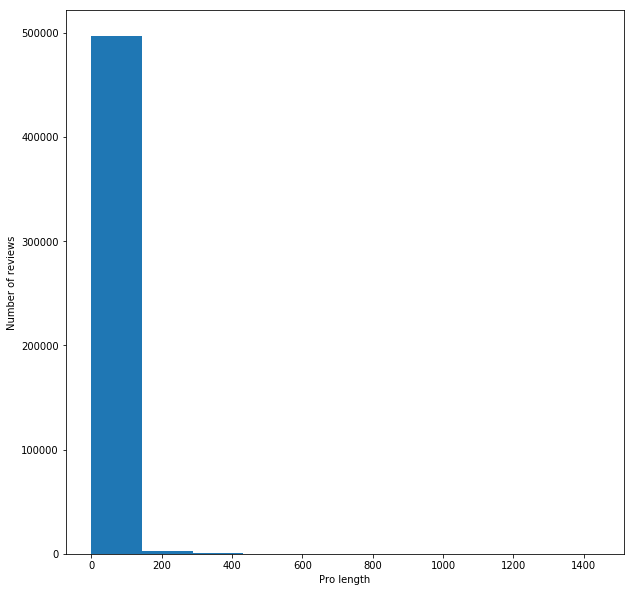

In [30]:
#Distribution of PROs review length

fig = plt.figure(figsize=(10,10))

plt.xlabel('Pro length')
plt.ylabel('Number of reviews')
plt.hist(pros_lengths)
plt.show();

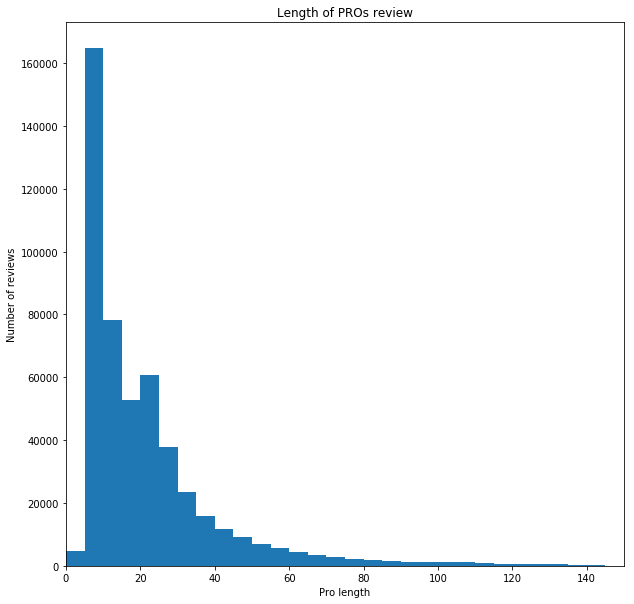

In [31]:
#Distribution of PRO review lengths, at most 150 words

fig = plt.figure(figsize=(10,10))

plt.xlabel('Pro length')
plt.ylabel('Number of reviews')
plt.hist(pros_lengths, bins=range(0,150,5))
plt.xlim(0,150)
plt.title('Length of PROs review')
plt.show();

We see that the vast majority of pros have length less than 60.

Now let's do the same for cons.

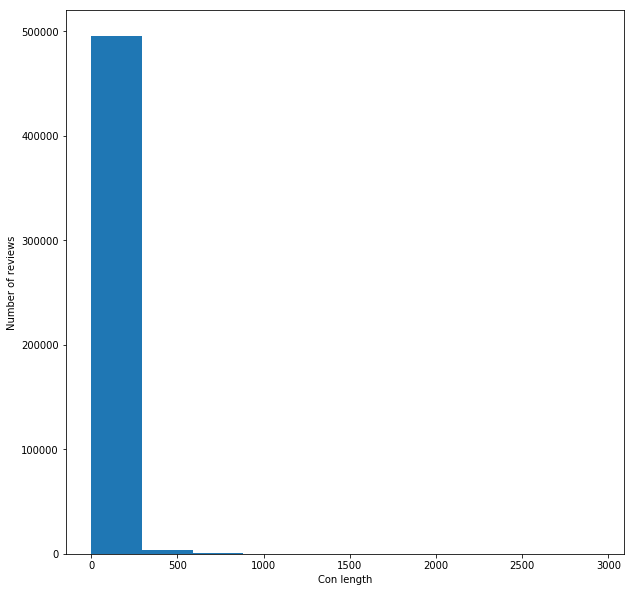

In [32]:
# distribution of CON review length

fig = plt.figure(figsize=(10,10))

plt.xlabel('Con length')
plt.ylabel('Number of reviews')
plt.hist(cons_lengths)
plt.show();

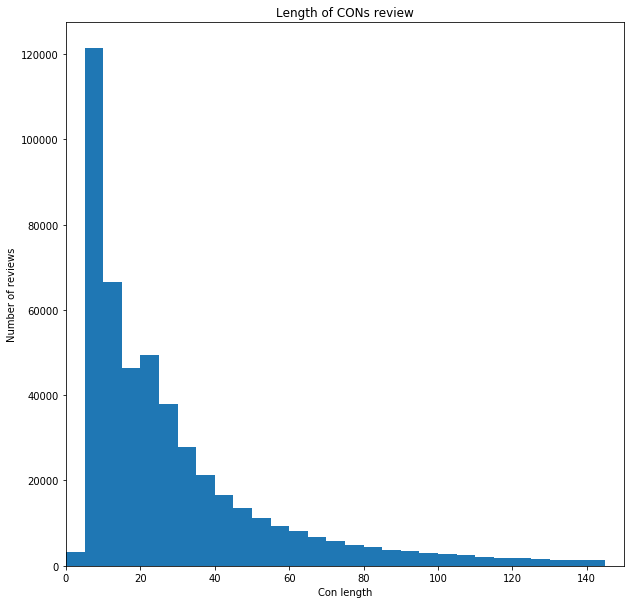

In [33]:
#let's try to zoom in one pro lengths less than 150
fig = plt.figure(figsize=(10,10))

plt.xlabel('Con length')
plt.ylabel('Number of reviews')
plt.hist(cons_lengths, bins=range(0,150,5))
plt.xlim(0,150)
plt.title('Length of CONs review')
plt.show();

We see that the CONs lengths tend to be a bit more spread out. This makes sense because people seem more likely to write gripes in CONs (associated with bad reviews) than go in detail to the good qualities of a job.

## Count Vectorize PROs and CONs

In [34]:
def cv(data):
    count_vectorizer = CountVectorizer(stop_words='english', max_features=10000)
    emb = count_vectorizer.fit_transform(data)
    
    return emb, count_vectorizer



list_corpus_pros = reviews_sample_pros_rating.loc[:,'PROs'].tolist()
list_corpus_cons = reviews_sample_cons_rating.loc[:,'CONs'].tolist()

list_labels = reviews_sample_pros_rating.loc[:,'review_at_least_4'].tolist()

pros_x_train, pros_x_test, pros_y_train, pros_y_test = train_test_split(list_corpus_pros, list_labels, test_size=0.4, random_state=23)
cons_x_train, cons_x_test, cons_y_train, cons_y_test = train_test_split(list_corpus_cons, list_labels, test_size=0.4, random_state=23)

pros_x_train_counts, count_vectorizer_pros = cv(pros_x_train)
pros_x_test_counts = count_vectorizer_pros.transform(pros_x_test)

cons_x_train_counts, count_vectorizer_cons = cv(cons_x_train)
cons_x_test_counts = count_vectorizer_cons.transform(cons_x_test)


### Truncated SVD on PROs and CONs

We will now apply Truncated SVD on the PROs and CONs. We will see some separation in both the PROs and CONs between high scoring reviews and low scoring ones in the first component. This gives us some hope classification can be accurate.

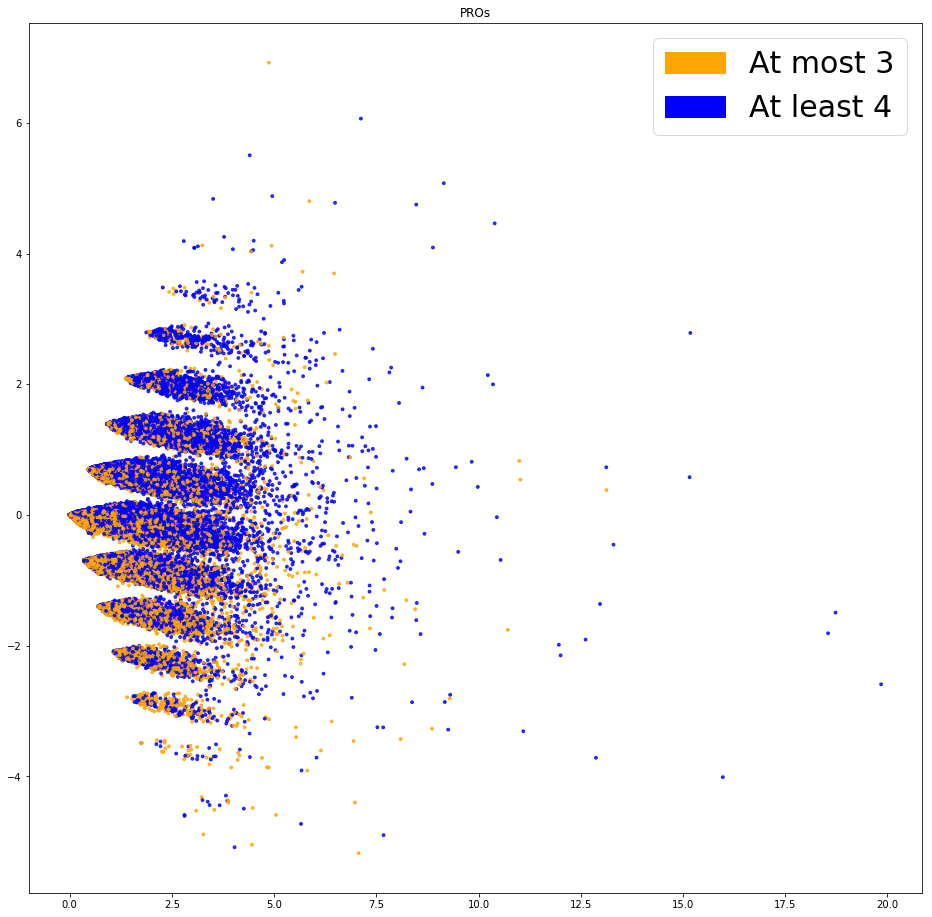

In [35]:
def plot_LSA(test_data, test_labels, savepath="PCA_reviews_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='At most 3')
            green_patch = mpatches.Patch(color='blue', label='At least 4')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(pros_x_train_counts, pros_y_train)
plt.title('PROs')
plt.show()

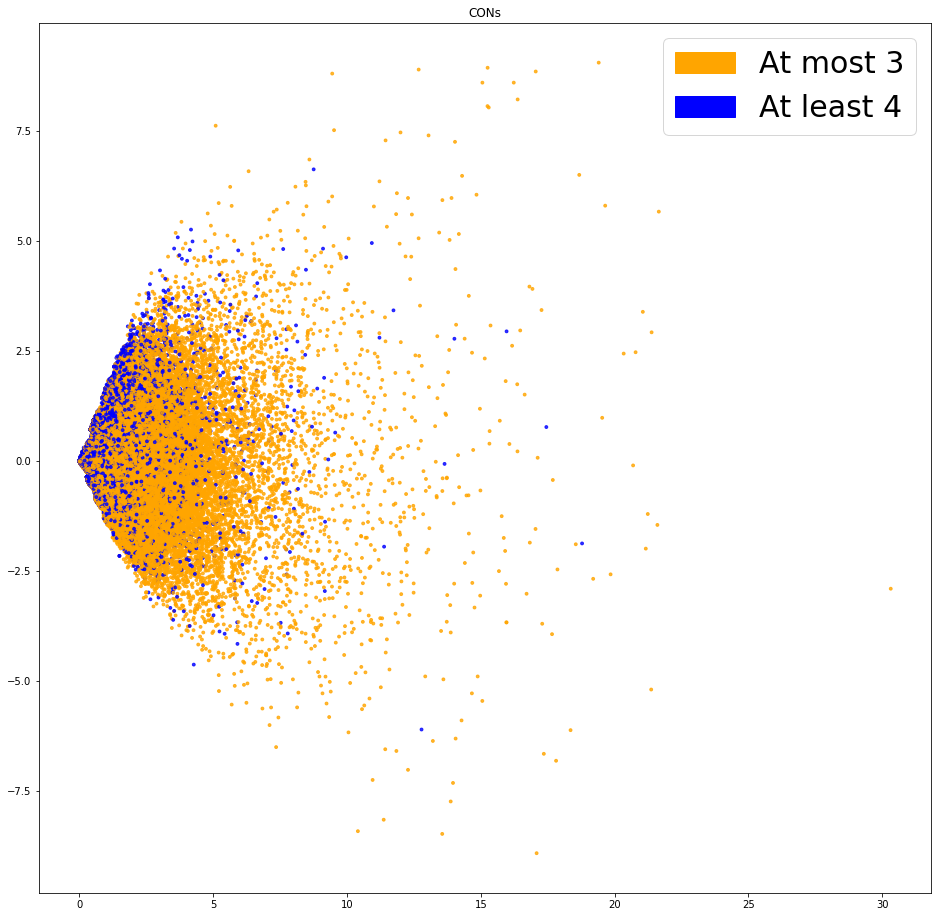

In [36]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(cons_x_train_counts, cons_y_train)
plt.title('CONs')
plt.show()

## Logistic Regression

In [37]:
start_time = time.time()

pros_clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                        multi_class='multinomial', n_jobs=-1, random_state=23)

cons_clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                        multi_class='multinomial', n_jobs=-1, random_state=23)


pros_clf.fit(pros_x_train_counts, pros_y_train)
cons_clf.fit(cons_x_train_counts, cons_y_train)

pros_y_predicted_counts = pros_clf.predict(pros_x_test_counts)
cons_y_predicted_counts = cons_clf.predict(cons_x_test_counts)

print('Took ' + str(time.time()-start_time) + ' seconds.')

Took 613.8295772075653 seconds.


In [38]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [39]:
pros_accuracy, pros_precision, pros_recall, pros_f1 = get_metrics(pros_y_test, pros_y_predicted_counts)

print("Pros")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (pros_accuracy, pros_precision, pros_recall, pros_f1))

cons_accuracy, cons_precision, cons_recall, cons_f1 = get_metrics(cons_y_test, cons_y_predicted_counts)

print('-'*50)

print("Cons")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (cons_accuracy, cons_precision, cons_recall, cons_f1))



Pros
accuracy = 0.687, precision = 0.687, recall = 0.687, f1 = 0.687
--------------------------------------------------
Cons
accuracy = 0.727, precision = 0.736, recall = 0.727, f1 = 0.726


## Use Tfidf vectorizer

In [40]:
'''
def tcv(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)
    emb = tfidf_vectorizer.fit_transform(data)
    
    return emb, tfidf_vectorizer

list_corpus_pros = reviews_sample_pros_rating.loc[:,'PROs'].tolist()
list_corpus_cons = reviews_sample_cons_rating.loc[:,'CONs'].tolist()

list_labels = reviews_sample_pros_rating.loc[:,'review_at_least_4'].tolist()

pros_x_train, pros_x_test, pros_y_train, pros_y_test = train_test_split(list_corpus_pros, list_labels, test_size=0.4, random_state=23)
cons_x_train, cons_x_test, cons_y_train, cons_y_test = train_test_split(list_corpus_cons, list_labels, test_size=0.4, random_state=23)

pros_x_train_counts, count_vectorizer_pros = tcv(pros_x_train)
pros_x_test_counts = count_vectorizer_pros.transform(pros_x_test)

cons_x_train_counts, count_vectorizer_cons = tcv(cons_x_train)
cons_x_test_counts = count_vectorizer_cons.transform(cons_x_test)
'''


"\ndef tcv(data):\n    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)\n    emb = tfidf_vectorizer.fit_transform(data)\n    \n    return emb, tfidf_vectorizer\n\nlist_corpus_pros = reviews_sample_pros_rating.loc[:,'PROs'].tolist()\nlist_corpus_cons = reviews_sample_cons_rating.loc[:,'CONs'].tolist()\n\nlist_labels = reviews_sample_pros_rating.loc[:,'review_at_least_4'].tolist()\n\npros_x_train, pros_x_test, pros_y_train, pros_y_test = train_test_split(list_corpus_pros, list_labels, test_size=0.4, random_state=23)\ncons_x_train, cons_x_test, cons_y_train, cons_y_test = train_test_split(list_corpus_cons, list_labels, test_size=0.4, random_state=23)\n\npros_x_train_counts, count_vectorizer_pros = tcv(pros_x_train)\npros_x_test_counts = count_vectorizer_pros.transform(pros_x_test)\n\ncons_x_train_counts, count_vectorizer_cons = tcv(cons_x_train)\ncons_x_test_counts = count_vectorizer_cons.transform(cons_x_test)\n"

In [41]:
'''
fig = plt.figure(figsize=(16, 16))          
plot_LSA(pros_x_train_counts, pros_y_train)
plt.title('PROs')
plt.show()
'''

"\nfig = plt.figure(figsize=(16, 16))          \nplot_LSA(pros_x_train_counts, pros_y_train)\nplt.title('PROs')\nplt.show()\n"

In [42]:
'''
fig = plt.figure(figsize=(16, 16))          
plot_LSA(cons_x_train_counts, cons_y_train)
plt.title('CONs')
plt.show()
'''

"\nfig = plt.figure(figsize=(16, 16))          \nplot_LSA(cons_x_train_counts, cons_y_train)\nplt.title('CONs')\nplt.show()\n"

In [43]:
'''
start_time = time.time()

pros_clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                        multi_class='multinomial', n_jobs=-1, random_state=23)

cons_clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                        multi_class='multinomial', n_jobs=-1, random_state=23)


pros_clf.fit(pros_x_train_counts, pros_y_train)

cons_clf.fit(cons_x_train_counts, cons_y_train)

pros_y_predicted_counts = pros_clf.predict(pros_x_test_counts)
cons_y_predicted_counts = cons_clf.predict(cons_x_test_counts)

print('Took ' + str(time.time()-start_time) + ' seconds.')
'''

"\nstart_time = time.time()\n\npros_clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',\n                        multi_class='multinomial', n_jobs=-1, random_state=23)\n\ncons_clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',\n                        multi_class='multinomial', n_jobs=-1, random_state=23)\n\n\npros_clf.fit(pros_x_train_counts, pros_y_train)\n\ncons_clf.fit(cons_x_train_counts, cons_y_train)\n\npros_y_predicted_counts = pros_clf.predict(pros_x_test_counts)\ncons_y_predicted_counts = cons_clf.predict(cons_x_test_counts)\n\nprint('Took ' + str(time.time()-start_time) + ' seconds.')\n"

In [44]:
'''def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1
    '''

"def get_metrics(y_test, y_predicted):  \n    # true positives / (true positives+false positives)\n    precision = precision_score(y_test, y_predicted, pos_label=None,\n                                    average='weighted')             \n    # true positives / (true positives + false negatives)\n    recall = recall_score(y_test, y_predicted, pos_label=None,\n                              average='weighted')\n    \n    # harmonic mean of precision and recall\n    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')\n    \n    # true positives + true negatives/ total\n    accuracy = accuracy_score(y_test, y_predicted)\n    return accuracy, precision, recall, f1\n    "

In [45]:
'''
pros_accuracy, pros_precision, pros_recall, pros_f1 = get_metrics(pros_y_test, pros_y_predicted_counts)

print("Pros")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (pros_accuracy, pros_precision, pros_recall, pros_f1))

cons_accuracy, cons_precision, cons_recall, cons_f1 = get_metrics(cons_y_test, cons_y_predicted_counts)

print('-'*50)

print("Cons")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (cons_accuracy, cons_precision, cons_recall, cons_f1))
'''

'\npros_accuracy, pros_precision, pros_recall, pros_f1 = get_metrics(pros_y_test, pros_y_predicted_counts)\n\nprint("Pros")\nprint("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (pros_accuracy, pros_precision, pros_recall, pros_f1))\n\ncons_accuracy, cons_precision, cons_recall, cons_f1 = get_metrics(cons_y_test, cons_y_predicted_counts)\n\nprint(\'-\'*50)\n\nprint("Cons")\nprint("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (cons_accuracy, cons_precision, cons_recall, cons_f1))\n'

In [46]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

pros_importance = get_most_important_features(count_vectorizer_pros, pros_clf, 10)

cons_importance = get_most_important_features(count_vectorizer_cons, cons_clf, 10)

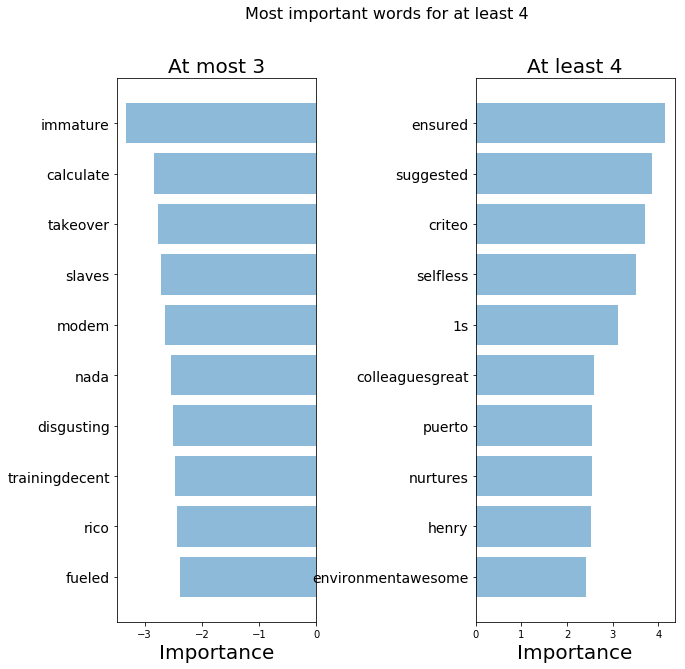

In [47]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('At most 3', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('At least 4', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in pros_importance[0]['tops']]
top_words = [a[1] for a in pros_importance[0]['tops']]
bottom_scores = [a[0] for a in pros_importance[0]['bottom']]
bottom_words = [a[1] for a in pros_importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for at least 4")

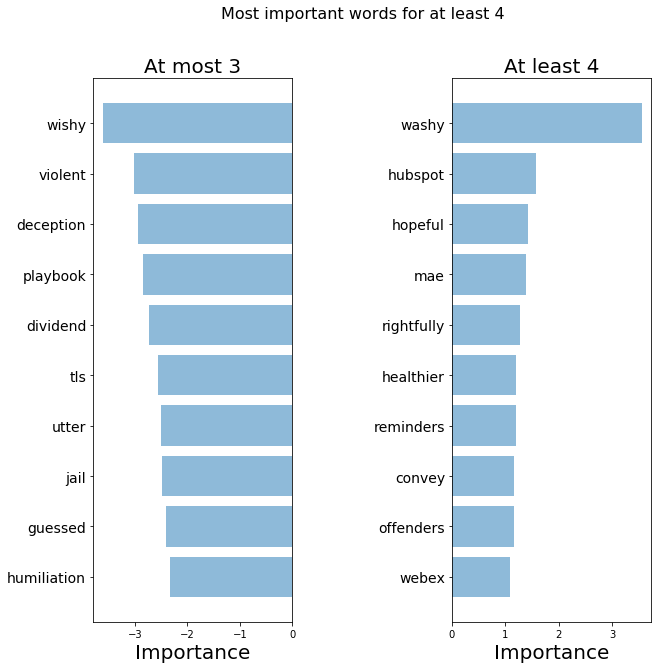

In [48]:

top_scores = [a[0] for a in cons_importance[0]['tops']]
top_words = [a[1] for a in cons_importance[0]['tops']]
bottom_scores = [a[0] for a in cons_importance[0]['bottom']]
bottom_words = [a[1] for a in cons_importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for at least 4")